# Using CharRNN Model and Vocab to train SMILES Generation Model

In [1]:
# change to the directory of the working file
%cd ..

/home/hudongcheng/Desktop/bo_osda_generator


In [2]:
import pandas as pd
from rdkit import Chem
import numpy as np
import random
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime

# import the necessary modules
from utils.utils import *
from datasets.data_loader import *
from models.RNN import *
from utils.metrics import *
from utils.plot_figures import *

In [3]:
cudnn.benchmark = True
cudnn.enabled = True

train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []

log_dir = './logs/'
save_best_weight_path = './checkpoints/'

now = datetime.now().strftime('%Y-%m-%d-%H-%M-%S')

In [4]:
PAD = 0
UNK = 1
EOS = 2
SOS = 3
MASK = 4
MAX_LEN = 220

In [5]:
# load the data
train_smiles = read_strings('./data/train_smiles.csv', idx=False)
train_zeo = read_vec('./data/train_zeo.csv', idx=False)
train_syn = read_vec('./data/train_syn.csv', idx=False)
train_codes = read_strings('./data/train_codes.csv', idx=False)
test_smiles = read_strings('./data/test_smiles.csv', idx=False)
test_zeo = read_vec('./data/test_zeo.csv', idx=False)
test_syn = read_vec('./data/test_syn.csv', idx=False)
test_codes = read_strings('./data/test_codes.csv', idx=False)

vocab = WordVocab.load_vocab('./model_hub/vocab.pkl')
print('the vocab size is :', len(vocab))

the vocab size is : 45


In [6]:
charlen = len(vocab)
print('the total num of charset is :', charlen)

cudnn.benchmark = True
lr = 4e-6
batch_size = 512
epoch = 30

manual_seed = 42
random.seed(manual_seed)
torch.manual_seed(manual_seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

the total num of charset is : 45


In [7]:
# create the dataset and dataloader
train_dataset = Seq2seqDataset(train_zeo, train_syn, train_smiles, vocab)
test_dataset = Seq2seqDataset(test_zeo, test_syn, test_smiles, vocab)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# load the model
model = RNNModel(input_size=charlen, 
                 synthesis_dim=24, 
                 embedding_dim=128,
                 hidden_size=256,
                 num_layers=3,
                 dropout=0,
                 vocab_size=charlen).to(device)

# define the loss function and the optimizer
loss_func = nn.CrossEntropyLoss(ignore_index=PAD) # ignore the padding index
optim = optim.Adam(model.parameters(), lr=lr)

total = sum(p.numel() for p in model.parameters())
print('total parameters: %0.2fM' % (total / 1e6))  # print the total parameters

total parameters: 0.39M


In [8]:
# train function
def train(model, train_dataloader, loss_func, optim, device):
    model.train()
    total_loss = 0
    total_acc = 0
    total_num = 0
    for i, (zeo, syn, tgt) in enumerate(tqdm(train_dataloader)):
        zeo = zeo.to(device)
        syn = syn.to(device)
        tgt = tgt.to(device)
        # concat zeo and syn as the input (prop)
        synthesis_condition = torch.cat([zeo, syn], dim=-1)
        tgt_input = tgt[:, :-1].contiguous()
        tgt_label = tgt[:, 1:].contiguous()
        
        # forward
        optim.zero_grad()
        output, _ = model(synthesis_condition, tgt_input)
        loss = loss_func(output.view(-1, output.size(-1)), tgt_label.view(-1))
        
        # calculate the accuracy
        pred = torch.argmax(output, dim=-1)
        num_correct = (pred == tgt_label) & (tgt_label != PAD)
        num_words = (tgt_label != PAD).sum().item()
        
        # backward
        loss.backward()
        optim.step()
        
        total_loss += loss.item()
        total_acc += num_correct.sum().item()
        total_num += num_words
    return total_loss / len(train_dataloader), total_acc / total_num

In [9]:

def evaluate(model, test_dataloader, loss_func, device):
    model.eval()
    total_loss = 0
    total_acc = 0
    total_num = 0
    with torch.no_grad():
        for i, (zeo, syn, tgt) in enumerate(tqdm(test_dataloader)):
            zeo = zeo.to(device)
            syn = syn.to(device)
            tgt = tgt.to(device)
            # concat zeo and syn as the input (prop)
            synthesis_condition = torch.cat([zeo, syn], dim=-1)
            tgt_input = tgt[:, :-1].contiguous()
            tgt_label = tgt[:, 1:].contiguous()
            # forward
            output, _ = model(synthesis_condition, tgt_input)
            loss = loss_func(output.view(-1, output.size(-1)), tgt_label.view(-1))
            # calculate the accuracy
            pred = torch.argmax(output, dim=-1)
            num_correct = (pred == tgt_label) & (tgt_label != PAD)
            num_words = (tgt_label != PAD).sum().item()
            total_loss += loss.item()
            total_acc += num_correct.sum().item()
            total_num += num_words
    return total_loss / len(test_dataloader), total_acc / total_num

In [10]:
# train the model
for i in range(epoch):
    train_loss, train_acc = train(model, train_dataloader, loss_func, optim, device)
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    print('epoch: %d, train loss: %.4f, train acc: %.4f' % (i, train_loss, train_acc))
    test_loss, test_acc = evaluate(model, test_dataloader, loss_func, device)
    test_loss_history.append(test_loss)
    test_acc_history.append(test_acc)
    print('epoch: %d test loss: %.4f, test acc: %.4f' % (i, test_loss, test_acc))
    if i == 0:
        best_acc = test_acc
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), save_best_weight_path + 'best_charnn_model.pth')
    torch.save(model.state_dict(), save_best_weight_path + 'last_charnn_model.pth')

100%|██████████| 2265/2265 [00:41<00:00, 54.42it/s]


epoch: 0, train loss: 2.1604, train acc: 0.4477


100%|██████████| 544/544 [00:06<00:00, 84.42it/s]


epoch: 0 test loss: 1.5495, test acc: 0.5892


 86%|████████▌ | 1944/2265 [00:36<00:05, 54.01it/s]

In [ ]:
def generate_rnn(model, start_sequence, condition_props, max_length, vocab, device, temperature=1.0, top_k=0):
    """
    Autoregressive generation process for a GPT model.

    Args:
        model (RNN): The pre-trained GPT model for token generation.
        start_sequence (torch.Tensor): The initial sequence to start generation (batch_size, seq_length).
        condition_props (torch.Tensor): The conditional property vector (batch_size, num_props).
        max_length (int): The maximum length of the generated sequence.
        vocab: The vocabulary object for encoding and decoding SMILES strings.
        device (torch.device): The device on which to run the generation.
        temperature (float): Temperature parameter for sampling; higher values increase randomness.
        top_k (int): Limits sampling to top-k logits; if 0, no top-k sampling is applied.

    Returns:
        List[str]: A list of generated SMILES strings.
    """
    model.eval()
    batch_size = start_sequence.size(0)
    generated_sequences = start_sequence.clone().to(device)  # Clone and move to device

    for _ in range(max_length - start_sequence.size(1)):
        # Get the current sequence length
        current_length = generated_sequences.size(1)

        # Forward pass through the model
        logits, _ = model(condition_props, generated_sequences)  # (batch_size, seq_length, vocab_size)

        # Extract the logits for the last time step
        next_token_logits = logits[:, -1, :]  # (batch_size, vocab_size)

        # Apply temperature scaling
        next_token_logits = next_token_logits / temperature

        # Apply top-k filtering
        if top_k > 0:
            top_k_logits, top_k_indices = torch.topk(next_token_logits, top_k, dim=-1)
            mask = torch.full_like(next_token_logits, float('-inf'))
            mask.scatter_(dim=-1, index=top_k_indices, src=top_k_logits)
            next_token_logits = mask

        # Convert logits to probabilities
        next_token_probs = F.softmax(next_token_logits, dim=-1)

        # Sample from the probability distribution
        next_token = torch.multinomial(next_token_probs, num_samples=1)  # (batch_size, 1)
        
        # Get the most likely next token
        # next_token = torch.argmax(next_token_logits, dim=-1, keepdim=True)

        # Append the generated token to the sequence
        generated_sequences = torch.cat([generated_sequences, next_token], dim=1)

        # Check if all sequences have reached the end token
        if all(next_token[i].item() == EOS for i in range(batch_size)):
            break

    # Decode the generated sequences into SMILES strings
    generated_smiles = []
    for seq in generated_sequences:
        # Convert indices to characters, ignoring padding and start tokens
        # check if the generated sequence contains the end token, if meet, stop decoding
        smiles = ''
        for idx in seq:
            if idx.item() == EOS:
                break
            elif idx.item() != PAD and idx.item() != SOS:
                smiles += vocab.itos[idx.item()]
        generated_smiles.append(smiles)

    return generated_smiles


In [ ]:
# generate the smiles for the test dataset
generated_smile = []
target_smile = []
for i, (zeo, syn, tgt) in enumerate(tqdm(test_dataloader)):
    zeo = zeo.to(device)
    syn = syn.to(device)
    tgt = tgt.to(device)
    condition_synthesis = torch.cat([zeo, syn], dim=1)
    generated_smiles = generate_rnn(model, tgt[:, :10], condition_synthesis, MAX_LEN, vocab, device, 0.5)
    generated_smile.extend(generated_smiles)
    # convert the tgt to smiles
    tgt_smiles = []
    for seq in tgt:
        smiles = ''
        for idx in seq:
            if idx.item() == EOS:
                break
            elif idx.item() != PAD and idx.item() != SOS:
                smiles += vocab.itos[idx.item()]
        tgt_smiles.append(smiles)
    target_smile.extend(tgt_smiles)

100%|██████████| 68/68 [01:23<00:00,  1.22s/it]


In [ ]:
# calculate the metrics
print('Validity rate:', validity_rate(generated_smiles))
print('Uniqueness rate:', uniqueness_rate(generated_smiles))
print('Novelty rate:', novelty_rate(generated_smiles, target_smile))
print('Reconstructability rate:', reconstructability_rate(generated_smiles, target_smile))
print('Novelty rate:', novelty_rate(generated_smiles, target_smile))
print('IntDiv:', IntDiv(generated_smiles))
# print('KL-divergence:', KL_divergence(target_smile), generated_smile))
print('FCD score:', FCD_score(target_smile, generated_smile))

[21:06:43] SMILES Parse Error: unclosed ring for input: 'C1CC2C(CCC[N+]1(C)CCCCCC2)CCC1'
[21:06:43] SMILES Parse Error: unclosed ring for input: 'C12CCC[N+]1(CC)CCCCC1'
[21:06:43] SMILES Parse Error: unclosed ring for input: 'C1CCCC[N+]1(C)CCCCC2'
[21:06:43] SMILES Parse Error: unclosed ring for input: 'C1CC2C([N+](C)(C)C)CCCC1'
[21:06:43] SMILES Parse Error: unclosed ring for input: 'C1C[N+]2(C)CCCCC1CCCCC[N+]2(C)CCCCCCCC1'
[21:06:43] SMILES Parse Error: unclosed ring for input: 'C1CCCC2[N+](CC)(CCCCCCC[N+]2(C)CCCCC1CCCCCCC1)C'
[21:06:43] SMILES Parse Error: extra open parentheses for input: 'C12C(CCC[N+](C)(CCCCCCCC2)CCCCCCCCCCCCCCCCCCCCC[N+]1(C)CCCCC1'
[21:06:43] SMILES Parse Error: unclosed ring for input: 'C1CCC[N+]1(C)CCCCCC1'
[21:06:43] SMILES Parse Error: unclosed ring for input: 'C1CCCC[N+]1(C)CCCCCCCCC1'
[21:06:43] SMILES Parse Error: unclosed ring for input: '[N+]12(C3CCCCCCC3)CCCC1'
[21:06:43] SMILES Parse Error: unclosed ring for input: 'C1c2c(cccc2)CCCC[N+]1(C)CCCCC1'
[21

Validity rate: 0.242
Uniqueness rate: 0.984
Novelty rate: 0.9939024390243902
Reconstructability rate: 0.006097560975609756
Novelty rate: 0.9939024390243902
IntDiv: 0.787244132164922


[21:06:46] SMILES Parse Error: unclosed ring for input: '[n+]1(Cc2ccccc1)CCCCCC1'
[21:06:46] SMILES Parse Error: extra open parentheses for input: 'c1cc(C[n+]1cc(C)n(C)c1C'
[21:06:46] Can't kekulize mol.  Unkekulized atoms: 0 1 2 15 16 17 18 19 20
[21:06:46] SMILES Parse Error: unclosed ring for input: 'c1n(C)c(C)c1C(C)CC[N+]1(C)CCCCCCCCCCCCCC[n+]1cccc1'
[21:06:46] Can't kekulize mol.  Unkekulized atoms: 0 4 8 9
[21:06:46] SMILES Parse Error: unclosed ring for input: 'n1(C)cc[n+]1CCCCCCC(C)C1'
[21:06:46] SMILES Parse Error: unclosed ring for input: 'c1cc(C[n+]3c(C)n(C)c(C)c1C)cc1'
[21:06:46] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5
[21:06:46] Can't kekulize mol.  Unkekulized atoms: 0 3 7
[21:06:46] Can't kekulize mol.  Unkekulized atoms: 0 1 4 8
[21:06:46] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
[21:06:46] Can't kekulize mol.  Unkekulized atoms: 0 4 5
[21:06:46] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 19 20 21 22
[21:06:46] SMILES Parse Error: unclosed ring

FCD score: 3.252191833755525


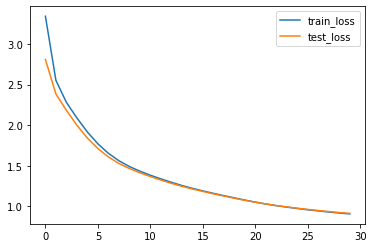

In [ ]:
# plot the training and testing loss
plot_loss(train_loss_history, test_loss_history, 'Charnn')